## Linear Discriminant Analysis, LDA
LDA is a supervised learning algorithm. While changing viewpoint, LDA wants to find a new axis that can differentiate labeled data.

http://sebastianraschka.com/Articles/2014_python_lda.html

In [1]:
# About the Iris dataset
feature_dict = {0: 'sepal length in cm',
                1: 'sepal width in cm',
                2: 'petal length in cm',
                3: 'petal width in cm'
               }
print(feature_dict)

{0: 'sepal length in cm', 1: 'sepal width in cm', 2: 'petal length in cm', 3: 'petal width in cm'}


In [2]:
# Reading in the dataset
import pandas as pd

df = pd.io.parsers.read_csv(
    #filepath_or_buffer='https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data', 
    filepath_or_buffer='iris.data',
    header=None, 
    sep=',', 
    )
df.columns = list(feature_dict.values()) + ['class label']
df.dropna(how="all", inplace=True) # to drop the empty line at file-end

df.tail()

,sepal length in cm,sepal width in cm,petal length in cm,petal width in cm,class label
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica
149,5.9,3.0,5.1,1.8,Iris-virginica


In [3]:
df.isnull().any()

sepal length in cm    False
sepal width in cm     False
petal length in cm    False
petal width in cm     False
class label           False
dtype: bool

In [4]:
df.describe()

,sepal length in cm,sepal width in cm,petal length in cm,petal width in cm
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667
std,0.828066,0.433594,1.764420,0.763161
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [5]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sb

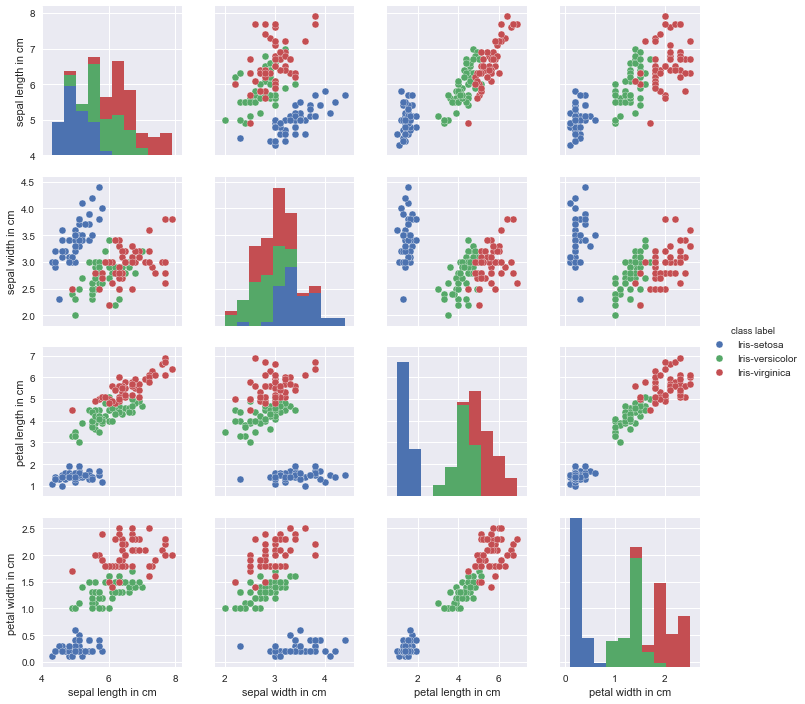

In [6]:
sb.pairplot(df, hue='class label')
# Check if there is any outliers!!!

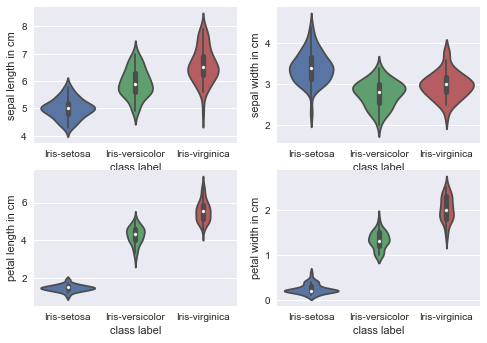

In [7]:
for column_index, column in enumerate(df.columns):
    if column == 'class label':
        continue
    plt.subplot(2, 2, column_index + 1)
    sb.violinplot(x='class label', y=column, data=df)

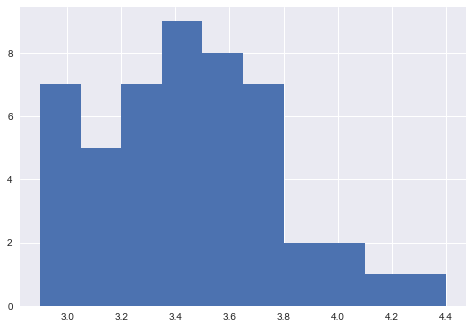

In [8]:
# If you want to clean the data, for example, Iris-setosa's sepal width is larger than 2.5cm.
# However, we do not clean the data here. You can try yourself.
df2 = df.loc[(df['class label'] == 'Iris-setosa') & (df['sepal width in cm'] > 2.5)]
df2['sepal width in cm'].hist()

In [9]:
X = df[[0,1,2,3]].values 
y = df['class label'].values

label_dict = {1: 'Setosa', 2: 'Versicolor', 3: 'Virginica'}

In [10]:
from sklearn.preprocessing import LabelEncoder
enc = LabelEncoder()
label_encoder = enc.fit(y)
y = label_encoder.transform(y) + 1

print(y)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3]


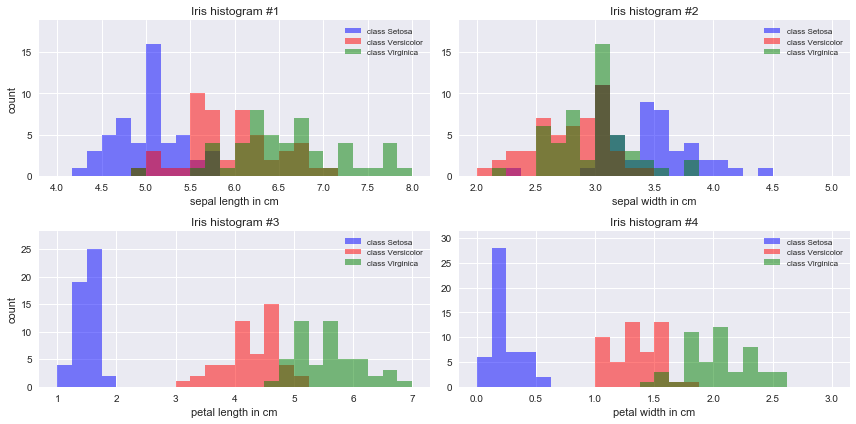

In [11]:
%matplotlib inline
# Histograms and feature selection
from matplotlib import pyplot as plt
import numpy as np
import math

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,6))

for ax,cnt in zip(axes.ravel(), range(4)):

    # set bin sizes
    min_b = math.floor(np.min(X[:,cnt]))
    max_b = math.ceil(np.max(X[:,cnt]))
    bins = np.linspace(min_b, max_b, 25)

    # plottling the histograms
    for lab,col in zip(range(1,4), ('blue', 'red', 'green')):
        ax.hist(X[y==lab, cnt],
                   color=col, 
                   label='class %s' %label_dict[lab], 
                   bins=bins,
                   alpha=0.5)
    ylims = ax.get_ylim()

    # plot annotation
    leg = ax.legend(loc='upper right', fancybox=True, fontsize=8)
    leg.get_frame().set_alpha(0.5)
    ax.set_ylim([0, max(ylims)+2])
    ax.set_xlabel(feature_dict[cnt])
    ax.set_title('Iris histogram #%s' %str(cnt+1))

    # hide axis ticks
    ax.tick_params(axis="both", which="both", bottom="off", top="off",  
            labelbottom="on", left="off", right="off", labelleft="on")

    # remove axis spines
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False) 
    ax.spines["bottom"].set_visible(False) 
    ax.spines["left"].set_visible(False)

axes[0][0].set_ylabel('count')
axes[1][0].set_ylabel('count')

fig.tight_layout()

plt.show()

In [12]:
# Standardization
orig_means = X.mean(axis=0)
orig_stds = X.std(axis=0)

for datapoint in X:
    for i in range(4):
        datapoint[i] = float(datapoint[i]-orig_means[i])/float(orig_stds[i])

In [13]:
#Step 1: Computing the d-dimensional mean vectors
np.set_printoptions(precision=4)

mean_vectors = []
for cl in range(1,4):
    mean_vectors.append(np.mean(X[y==cl], axis=0))
    print('Mean Vector class %s: %s' %(cl, mean_vectors[cl-1]))

Mean Vector class 1: [-1.0146  0.8423 -1.3049 -1.2551]
Mean Vector class 2: [ 0.1123 -0.6572  0.2851  0.1674]
Mean Vector class 3: [ 0.9023 -0.1851  1.0198  1.0877]


In [14]:
#Within-class scatter matrix SW
S_W = np.zeros((4,4))
for cl,mv in zip(range(1,4), mean_vectors):
    class_sc_mat = np.zeros((4,4))                  # scatter matrix for every class
    for row in X[y == cl]:
        row, mv = row.reshape(4,1), mv.reshape(4,1) # make column vectors
        class_sc_mat += (row-mv).dot((row-mv).T)
    S_W += class_sc_mat                             # sum class scatter matrices

print('within-class Scatter Matrix:')
print(S_W)

within-class Scatter Matrix:
[[ 57.1941  38.3652  16.9598   9.0095]
 [ 38.3652  91.2179  10.685   14.9475]
 [ 16.9598  10.685    8.8022   4.6754]
 [  9.0095  14.9475   4.6754  10.6746]]


In [15]:
#Between-class scatter matrix SB
overall_mean = np.mean(mean_vectors, axis=0)

S_B = np.zeros((4,4))
for i,mean_vec in enumerate(mean_vectors):  
    n = X[y==i+1,:].shape[0]
    mean_vec = mean_vec.reshape(4,1) # make column vector
    S_B += n * (mean_vec - overall_mean).dot((mean_vec - overall_mean).T)

print('between-class Scatter Matrix:')
print(S_B)

between-class Scatter Matrix:
[[ 371.2234 -219.0824  455.2134  454.734 ]
 [-219.0824  235.1285 -295.0497 -273.7166]
 [ 455.2134 -295.0497  564.7914  558.9527]
 [ 454.734  -273.7166  558.9527  557.3016]]


In [16]:
# Solving the generalized eigenvalue problem for the matrix SW-1SB

eig_vals, eig_vecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))

for i in range(len(eig_vals)):
    eigvec_sc = eig_vecs[:,i].reshape(4,1)   
    print('\nEigenvector {}: \n{}'.format(i+1, eigvec_sc.real))
    print('Eigenvalue {:}: {:.2e}'.format(i+1, eig_vals[i].real))


Eigenvector 1: 
[[-0.1498]
 [-0.1482]
 [ 0.8511]
 [ 0.4808]]
Eigenvalue 1: 1.29e+02

Eigenvector 2: 
[[ 0.0095]
 [ 0.3272]
 [-0.5748]
 [ 0.75  ]]
Eigenvalue 2: 1.11e+00

Eigenvector 3: 
[[ 0.5903]
 [ 0.0336]
 [ 0.2874]
 [-0.7535]]
Eigenvalue 3: 1.22e-14

Eigenvector 4: 
[[ 0.3748]
 [-0.1806]
 [-0.8084]
 [ 0.4163]]
Eigenvalue 4: -2.66e-14


In [17]:
# Step 4: Selecting linear discriminants for the new feature subspace
# Make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eig_pairs = sorted(eig_pairs, key=lambda k: k[0], reverse=True)

# Visually confirm that the list is correctly sorted by decreasing eigenvalues

print('Eigenvalues in decreasing order:')
for i in eig_pairs:
    print(i[0])

print 
print('Variance explained:')
eigv_sum = sum(eig_vals)
for i,j in enumerate(eig_pairs):
    print('eigenvalue {0:}: {1:.2%}'.format(i+1, (j[0]/eigv_sum).real))

Eigenvalues in decreasing order:
129.087831199
1.11026745536
2.65721252098e-14
1.21722363073e-14
Variance explained:
eigenvalue 1: 99.15%
eigenvalue 2: 0.85%
eigenvalue 3: 0.00%
eigenvalue 4: 0.00%


In [18]:
# Choosing k eigenvectors with the largest eigenvalues
W = np.hstack((eig_pairs[0][1].reshape(4,1), eig_pairs[1][1].reshape(4,1)))
print('Matrix W:')
print(W.real.T)

Matrix W:
[[-0.1498 -0.1482  0.8511  0.4808]
 [ 0.0095  0.3272 -0.5748  0.75  ]]


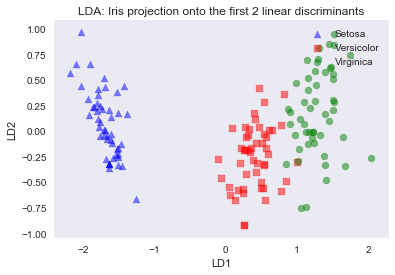

In [19]:
# Step 5: Transforming the samples onto the new subspace

X_lda = W.T.dot(X.T).T
assert X_lda.shape == (150,2), "The matrix is not 2x150 dimensional."
def plot_step_lda():

    ax = plt.subplot(111)
    for label,marker,color in zip(
        range(1,4),('^', 's', 'o'),('blue', 'red', 'green')):

        plt.scatter(x=X_lda[:,0][y == label],
                y=X_lda[:,1][y == label],
                marker=marker,
                color=color,
                alpha=0.5,
                label=label_dict[label]
                )

    plt.xlabel('LD1')
    plt.ylabel('LD2')

    leg = plt.legend(loc='upper right', fancybox=True)
    leg.get_frame().set_alpha(0.5)
    plt.title('LDA: Iris projection onto the first 2 linear discriminants')

    # hide axis ticks
    plt.tick_params(axis="both", which="both", bottom="off", top="off",  
            labelbottom="on", left="off", right="off", labelleft="on")

    # remove axis spines
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False) 
    ax.spines["bottom"].set_visible(False) 
    ax.spines["left"].set_visible(False)

    plt.grid()
    plt.tight_layout
    plt.show()

plot_step_lda()

### sklearnLDA Approach

In [20]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# LDA
sklearn_lda = LDA(n_components=2)
X_lda_sklearn = sklearn_lda.fit_transform(X, y)

In [21]:
def plot_scikit_lda(X, title):

    ax = plt.subplot(111)
    for label,marker,color in zip(
        range(1,4),('^', 's', 'o'),('blue', 'red', 'green')):

        plt.scatter(x=X[:,0][y == label],
                    y=X[:,1][y == label] * -1, # flip the figure
                    marker=marker,
                    color=color,
                    alpha=0.5,
                    label=label_dict[label])

    plt.xlabel('LD1')
    plt.ylabel('LD2')

    leg = plt.legend(loc='upper right', fancybox=True)
    leg.get_frame().set_alpha(0.5)
    plt.title(title)

    # hide axis ticks
    plt.tick_params(axis="both", which="both", bottom="off", top="off",  
            labelbottom="on", left="off", right="off", labelleft="on")

    # remove axis spines
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)    

    plt.grid()
    plt.tight_layout
    plt.show()

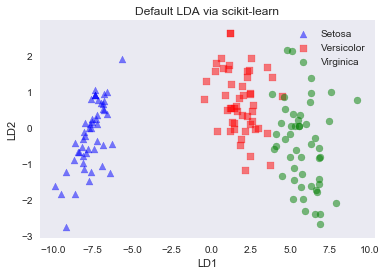

In [22]:
plot_scikit_lda(X_lda_sklearn, title='Default LDA via scikit-learn')